# Stroke prediction

Stroke is one of the most dangerous diseases that can occur at any time to anyone. It often leads patients to severe disability or even death. According to the National Institute of Neurological Disorders and Stroke, approximately 800,000 people suffered from a stroke in the United States **[[1]](https://www.usnews.com/news/health-news/articles/2024-05-23/stroke-rates-are-rising-especially-among-the-young)**. Moreover, the percentage of stroke occurrence of people under age 65 increased by approximately 15% from 2011 to 2022 **[[2]](https://www.ninds.nih.gov/health-information/public-education/brain-basics/brain-basics-preventing-stroke)**. Identifying the features that cause stroke and predicting it could be crucial to prevent stroke and reduce its impact.This project will focus on exploring which features affect stroke and make prediction based on the data by performing machine learning techniques (**Logistic Regression, KNN, and Random Forest**).

# 1. Data explanation

### 1.1 data explanation

For this project, a dataset including stroke occurrence, patients' medical conditions, health status, and relevant environmental factors was required. After reviewing several online platforms that provide datasets, a suitable dataset was found on Kaggle. This dataset was published on January 26, 2021, by Soriano and includes various features related to stroke **[[3]](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)**.  

**All the citations are listed in the Citation section at the bottom**

### 1.2 data description

The data from kaggle includes **5110 observations with 12 features**. Out of the 12 features, One feature is an identifier, One feature is a dependent variable, and ten are independent variables. Eight features are categorical variables and three features are continuous variables. 

Here is a brief description of the features.


|Variable |	Description| type| Value|
|:---------|:---------------------------|:---------------------------|:---------------------------|
|id 	|Identification|   -|         -|
|stroke |	whether a stroke has occurred or not <br>| Categorical Variable, Binary |1 = yes, 0 = no|
|gender |	patients' gender| Categorical Variable, Binary|Male, Female| 
|hypertension |	whether a patient has hypertension| Categorical Variable, Binary|1 = yes, 0 = no|
|heart_disease |	whether a patient has heart disease| Categorical Variable, Binary|1 = yes, 0 = no |
|ever_married |	whether a patient has married| Categorical Variable, Binary|yes, no|
|Residence_type| 	patients' residence type| Categorical Variable, Binary|Urban, Rural|
|work_type |	patients' work type| Categorical Variable, non-Binary|Govt_job, Private, Self-employed, Children, Never-worked|
|smoking_status |	whether a patient has smoked.| Categorical Variable, non-Binary|smokes, Unknown, formerly smoked, never smoked|
|age |	patients' age| Continuous Variable |from 0 to 82|
|avg_glucose_level|	patients' average glucose level| Continuous Variable|from 0 to 272|
|bmi |	patients' bmi| Continuous Variable|from 0 to 98|

### 1.3 Downloading pacakges

In [1]:
#download imbalanced-learn for SMOTE
#!pip install imbalanced-learn

#install if version complict between ibmlearn and sklearn

# !pip install scikit-learn==1.4.1.post1
# !pip install imbalanced-learn==0.12.2

#import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from imblearn.over_sampling import SMOTE

# 2. Data cleaning

In this section, data cleaning is performed on the stroke dataset to prepare for the following EDA and model creation. Before starting the cleaning phase, a brief overview of the data is provided.

In [2]:
#import data from CSV file
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### 2.1 Drop missing/null data

At this point, There is some Null count in the bmi column, which is less than 4% of total data. The percentage can be considered as small amount and impact of dropping missing value will be small. Thus, The decision was made to drop missing values.

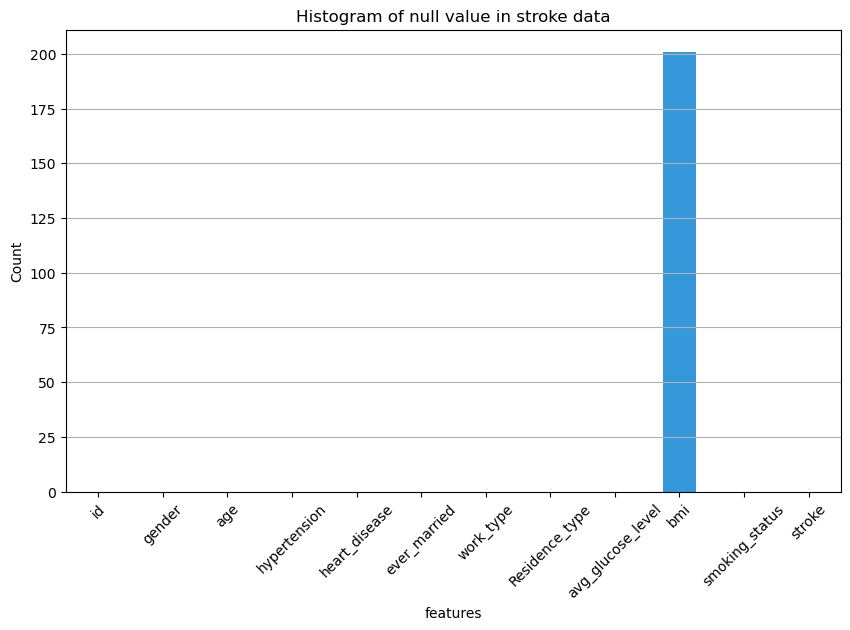

In [3]:
#counting null
null_count = df.isnull().sum()

#plot histogram for null counting
plt.figure(figsize = (10, 6))
null_count.plot(kind = "bar", color = "#3498db")
plt.title("Histogram of null value in stroke data")
plt.xlabel("features")
plt.xticks(rotation = 45)
plt.ylabel("Count")
plt.grid(True, axis = "y") 

plt.show()

In [4]:
#drop row with null in bmi
df = df.dropna(subset = ["bmi"])

#checking dropna work well
print(df.isnull().sum())

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


### 2.2 Drop non relevant column

Among the 11 features in the dataset, id feature isn't relevant to stroke prediction. Therefore, The decision was made to drop id feature.

In [5]:
df = df.drop(columns = ["id"])

#check drop id work well
print(df.columns)

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


### 2.3 Categorical variable processing

The categorical variables in the dataset are not consistently binary as observed in section 1.2. To prevent potential issues from data inconsistency and to ensure consistency across categorical variables, the data was processed using labeling.

In [6]:
#categorical data encoding
#binary
df["gender"] = df["gender"].map({"Male": 0, "Female": 1})
df["ever_married"] = df["ever_married"].map({"No": 0, "Yes": 1})
df["Residence_type"] = df["Residence_type"].map({"Rural": 0, "Urban": 1})
df["work_type"] = df["work_type"].map({"Private": 0, "Self-employed": 1, "Govt_job": 2, "children" : 3, "Never_worked": 4})
df["smoking_status"] = df["smoking_status"].map({"never smoked": 0, "formerly smoked": 1, "smokes": 2, "Unknown": 3})

#remove nan
# after processing categorical variables
# one gender appeared as null
# this line of code is for deleting null gender row
# delete one row might not affect to data and model
df = df.dropna()

In [7]:
#check data processing work well
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 4908 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4908 non-null   float64
 1   age                4908 non-null   float64
 2   hypertension       4908 non-null   int64  
 3   heart_disease      4908 non-null   int64  
 4   ever_married       4908 non-null   int64  
 5   work_type          4908 non-null   int64  
 6   Residence_type     4908 non-null   int64  
 7   avg_glucose_level  4908 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     4908 non-null   int64  
 10  stroke             4908 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 460.1 KB


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0.0,67.0,0,1,1,0,1,228.69,36.6,1,1
2,0.0,80.0,0,1,1,0,0,105.92,32.5,0,1
3,1.0,49.0,0,0,1,0,1,171.23,34.4,2,1
4,1.0,79.0,1,0,1,1,0,174.12,24.0,0,1
5,0.0,81.0,0,0,1,0,1,186.21,29.0,1,1


### 2.4 Data cleaning conclusion or discussions

To sum up, it was found that approximately four percent of the total data included null.One feature was not relevant to the prediction and models. Therefore, 202 rows were dropped from the dataset, and the id feature was dropped(The visualization of non-null count and null value count is placed below). Eight categorical features were processed into integer-encodied values by labling. As a result of this processing, binary categorical variables have consistency(yes = 1, no = 0) and non-binary categorical variables are encoded as integers now.

This data cleaning process was partialy done for EDA. More data cleaning will be performed after imbalance dignosis, outlier analysis and additional EDA process if needed. 

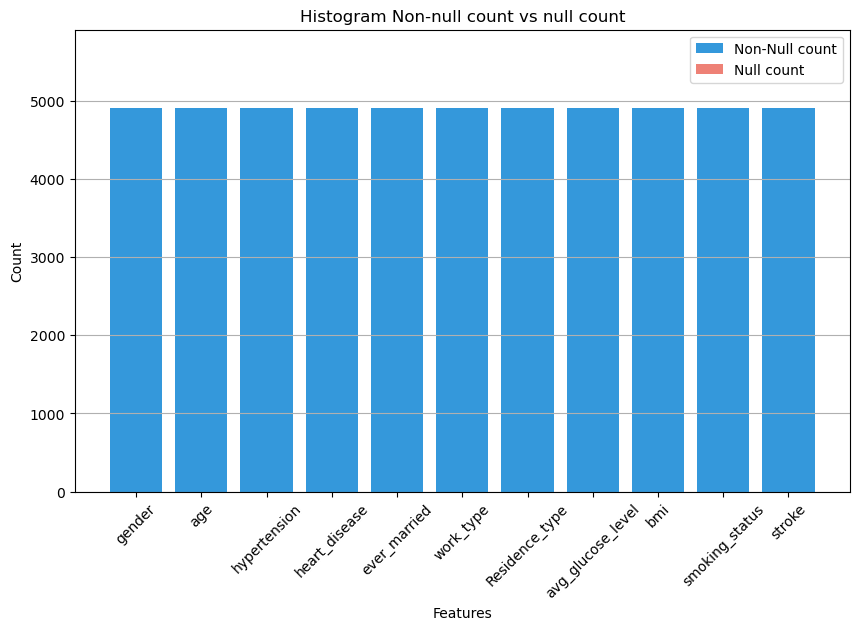

In [8]:
null_count = df.isnull().sum()
non_null_count = df.notnull().sum()

#plot histogram for null counting
plt.figure(figsize = (10, 6))
plt.bar(null_count.index, non_null_count, color = "#3498db", label = "Non-Null count")

plt.bar(null_count.index, null_count, bottom = non_null_count, color = "#e74c3c", alpha = 0.7, label = "Null count")

plt.title("Histogram Non-null count vs null count")
plt.xlabel("Features")
plt.xticks(rotation = 45)
plt.ylabel("Count")
plt.ylim(0, non_null_count.max() + null_count.max() + 1000)
plt.legend()
plt.grid(True, axis = "y")
plt.show()

# 3. EDA

Up to the previous section, data cleaning was performed on the raw stroke data. The purpose of this EDA section is to explore and understand the data from the previous section to help in prediction and model creation. This EDA will include exploring characteristics of features, checking for outliers, collinearity and correlation, data imbalance, and feature importance (if possible). Based on these diagnoses, additional data cleaning will be performed at the end of this section if needed.

### 3.1 Histogram of features

By analyzing the histograms below, some interesting patterns and potential problems were identified in the data. 
1. Some features share similar histogram shapes. 
    * **hypertension, heart_disease and stroke**. 
    * **gender and marriage status**. 
    * **average glucose level and bmi** 
    <br><br>
2. Some features have similar distribution patterns.
    * **gender and marriage status** are skewed toward value 1
    * **hypertension, heart_disease and stroke** are skewed toward value 0
    * **work type** are skewed toward value 0.
    <br><br>
3. Some ouliters are existing in **average glucose level**.
    <br><br>
4. Imbalance problem exists in the data.

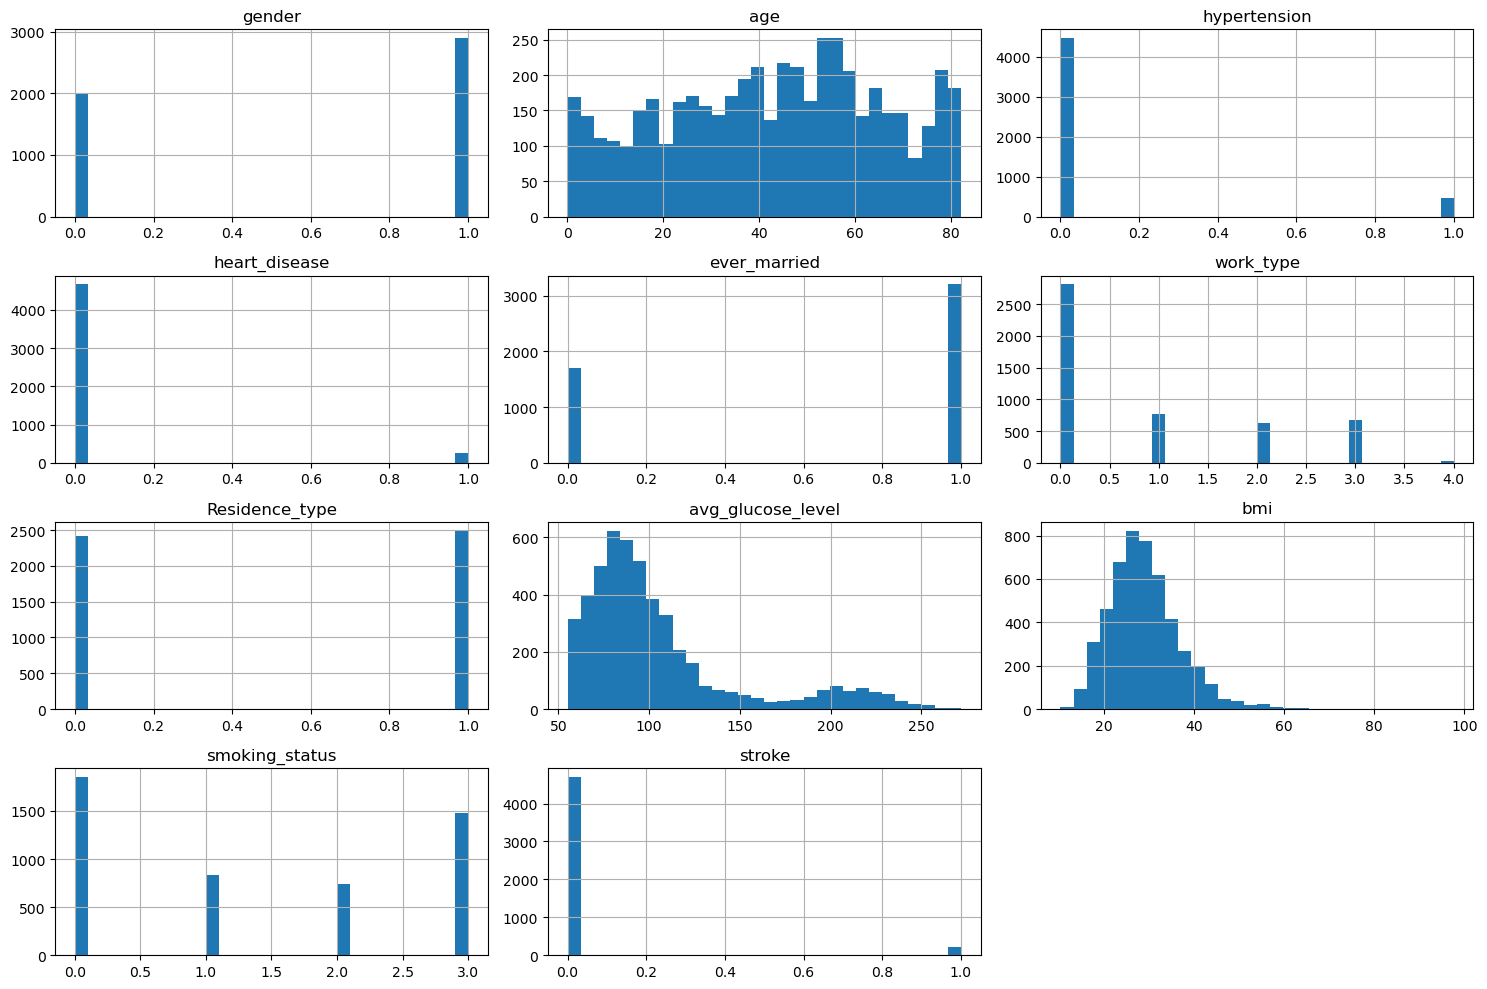

In [9]:
#create histogram of data features
df.hist(bins = 30, figsize = (15, 10))
plt.tight_layout()
plt.show()

### 3.2 Outlier Dignosis

In the previous section, some outliers were found in the average glucose level. By plotting a box plot of average glucose level, it was confirmed that several outliers exist. However, in medical data, outliers can sometimes be meaningful. Therefore, the decision was made to keep these outliers rather than dropping them.

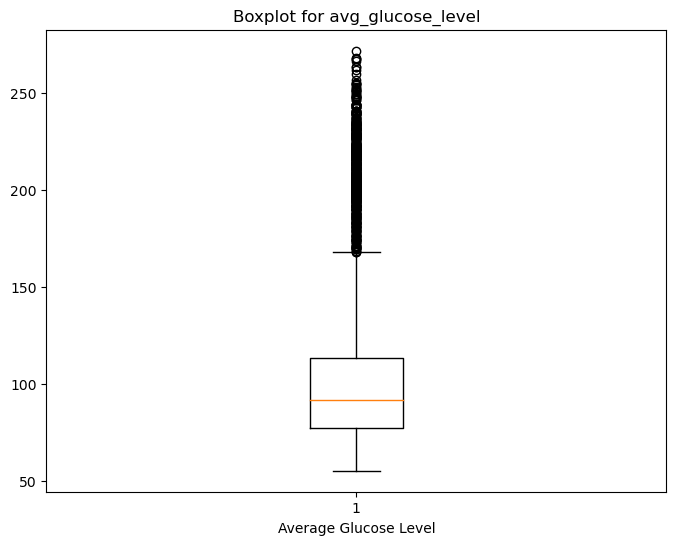

In [10]:
plt.figure(figsize = (8, 6))
plt.boxplot(df["avg_glucose_level"])
plt.title("Boxplot for avg_glucose_level")
plt.xlabel("Average Glucose Level")
plt.show()

### 3.3 correlation and collinearity

To inspect correlation and collinearity among features in the data, a heat map and pair plot were created. 

In the heat map, attention was drawn to the correlation between age and marriage status(correlation value of 0.68), which is considered a strong correlation in the data.
Additionally, there are six moderate correlations: 
1. three positive moderate correlations between **[age and BMI]**, **[marriage status and BMI]**, and **[work type and smoking status]**,
2. three negative moderate correlations between **[age and work type]**, **[age and smoking status]**, and **[work type and BMI]**. 
3. Other correlations were shown to be weak or nonexistent.


In the second plot(pair plot), there was no notable collinearity among features. Moreover, VIF test results confirmed that there is no collinearity among the features. Every VIF score is around 1 and 2, which is considered as no collinearity.





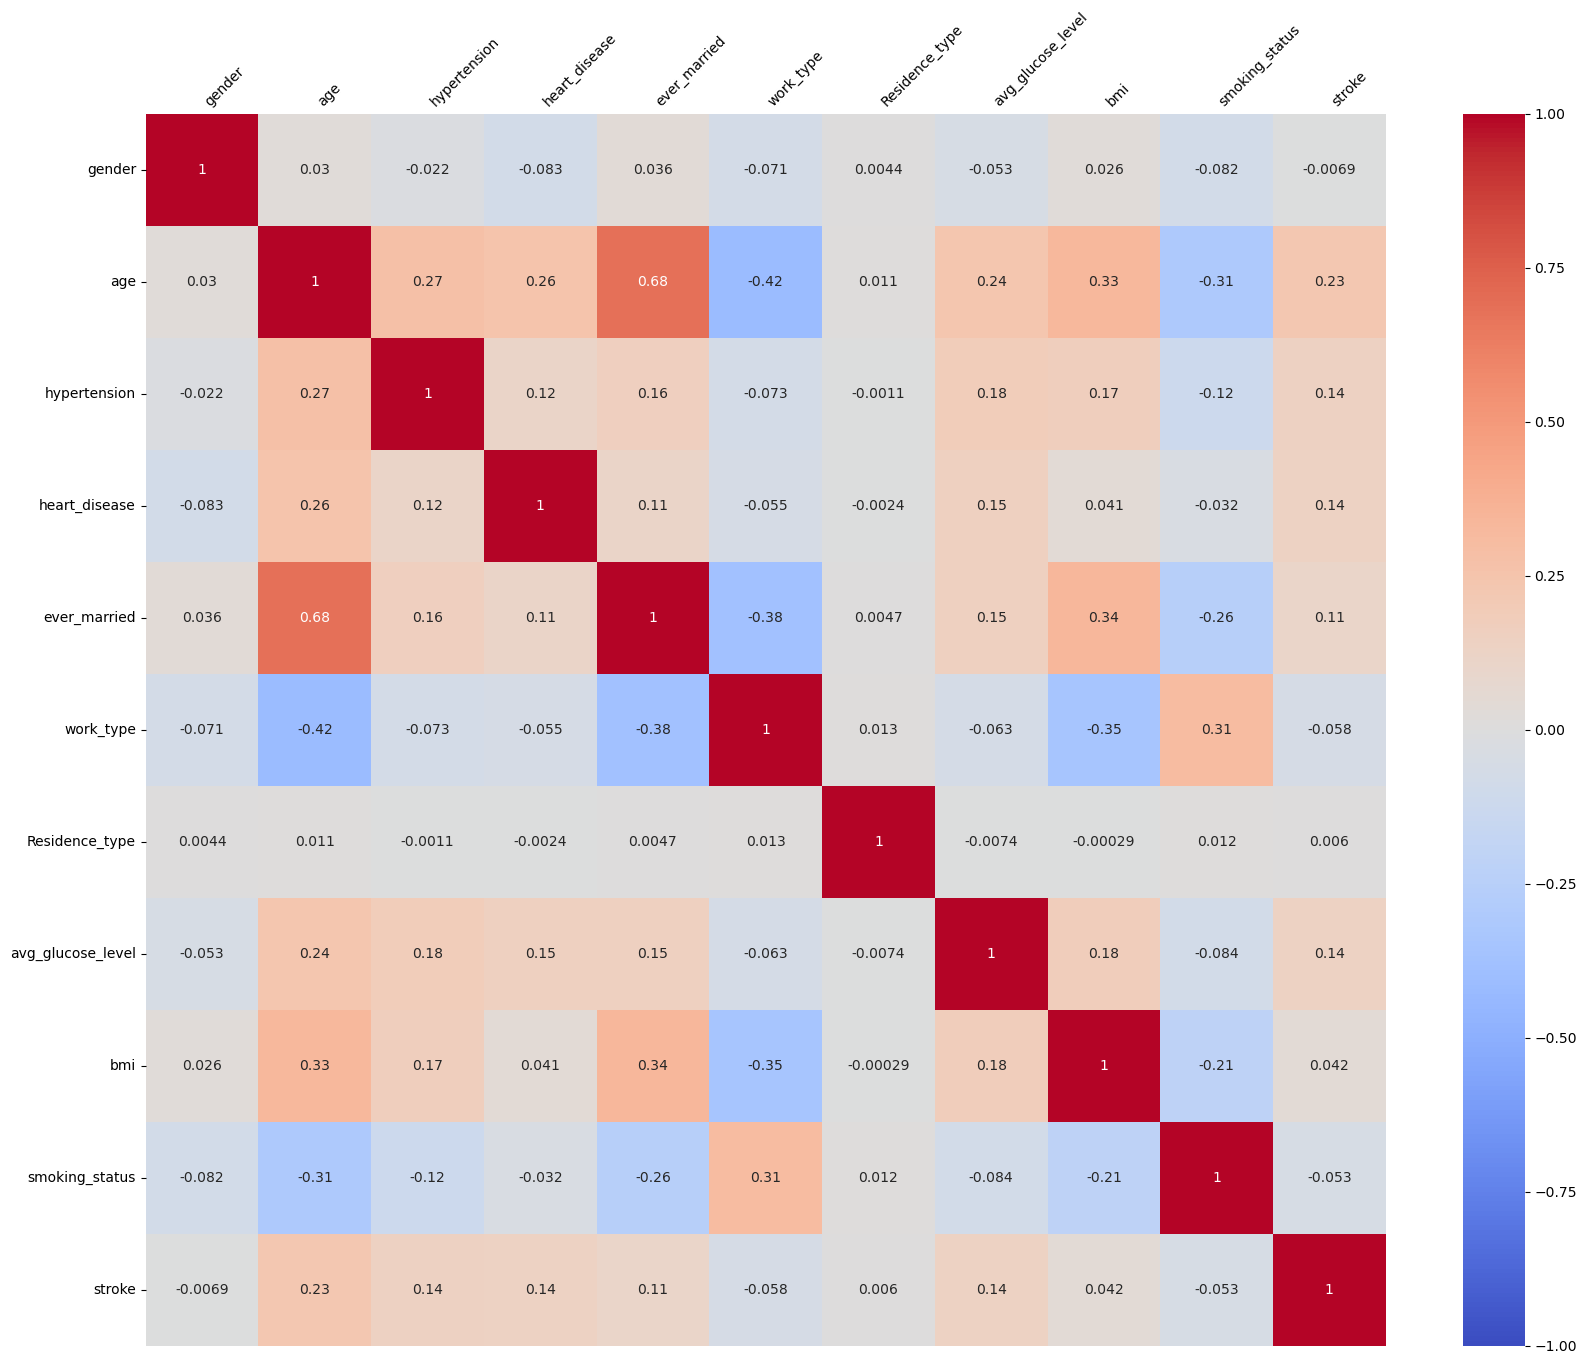

In [11]:
plt.figure(figsize = (20,16))
heat_map = sns.heatmap(df.corr(), annot = True, cmap = "coolwarm" , vmin = -1, vmax = 1)
heat_map.xaxis.tick_top()

plt.xticks(rotation = 45, ha = "left")
heat_map.tick_params(axis = "x", which = "both", length = 0)

D:\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


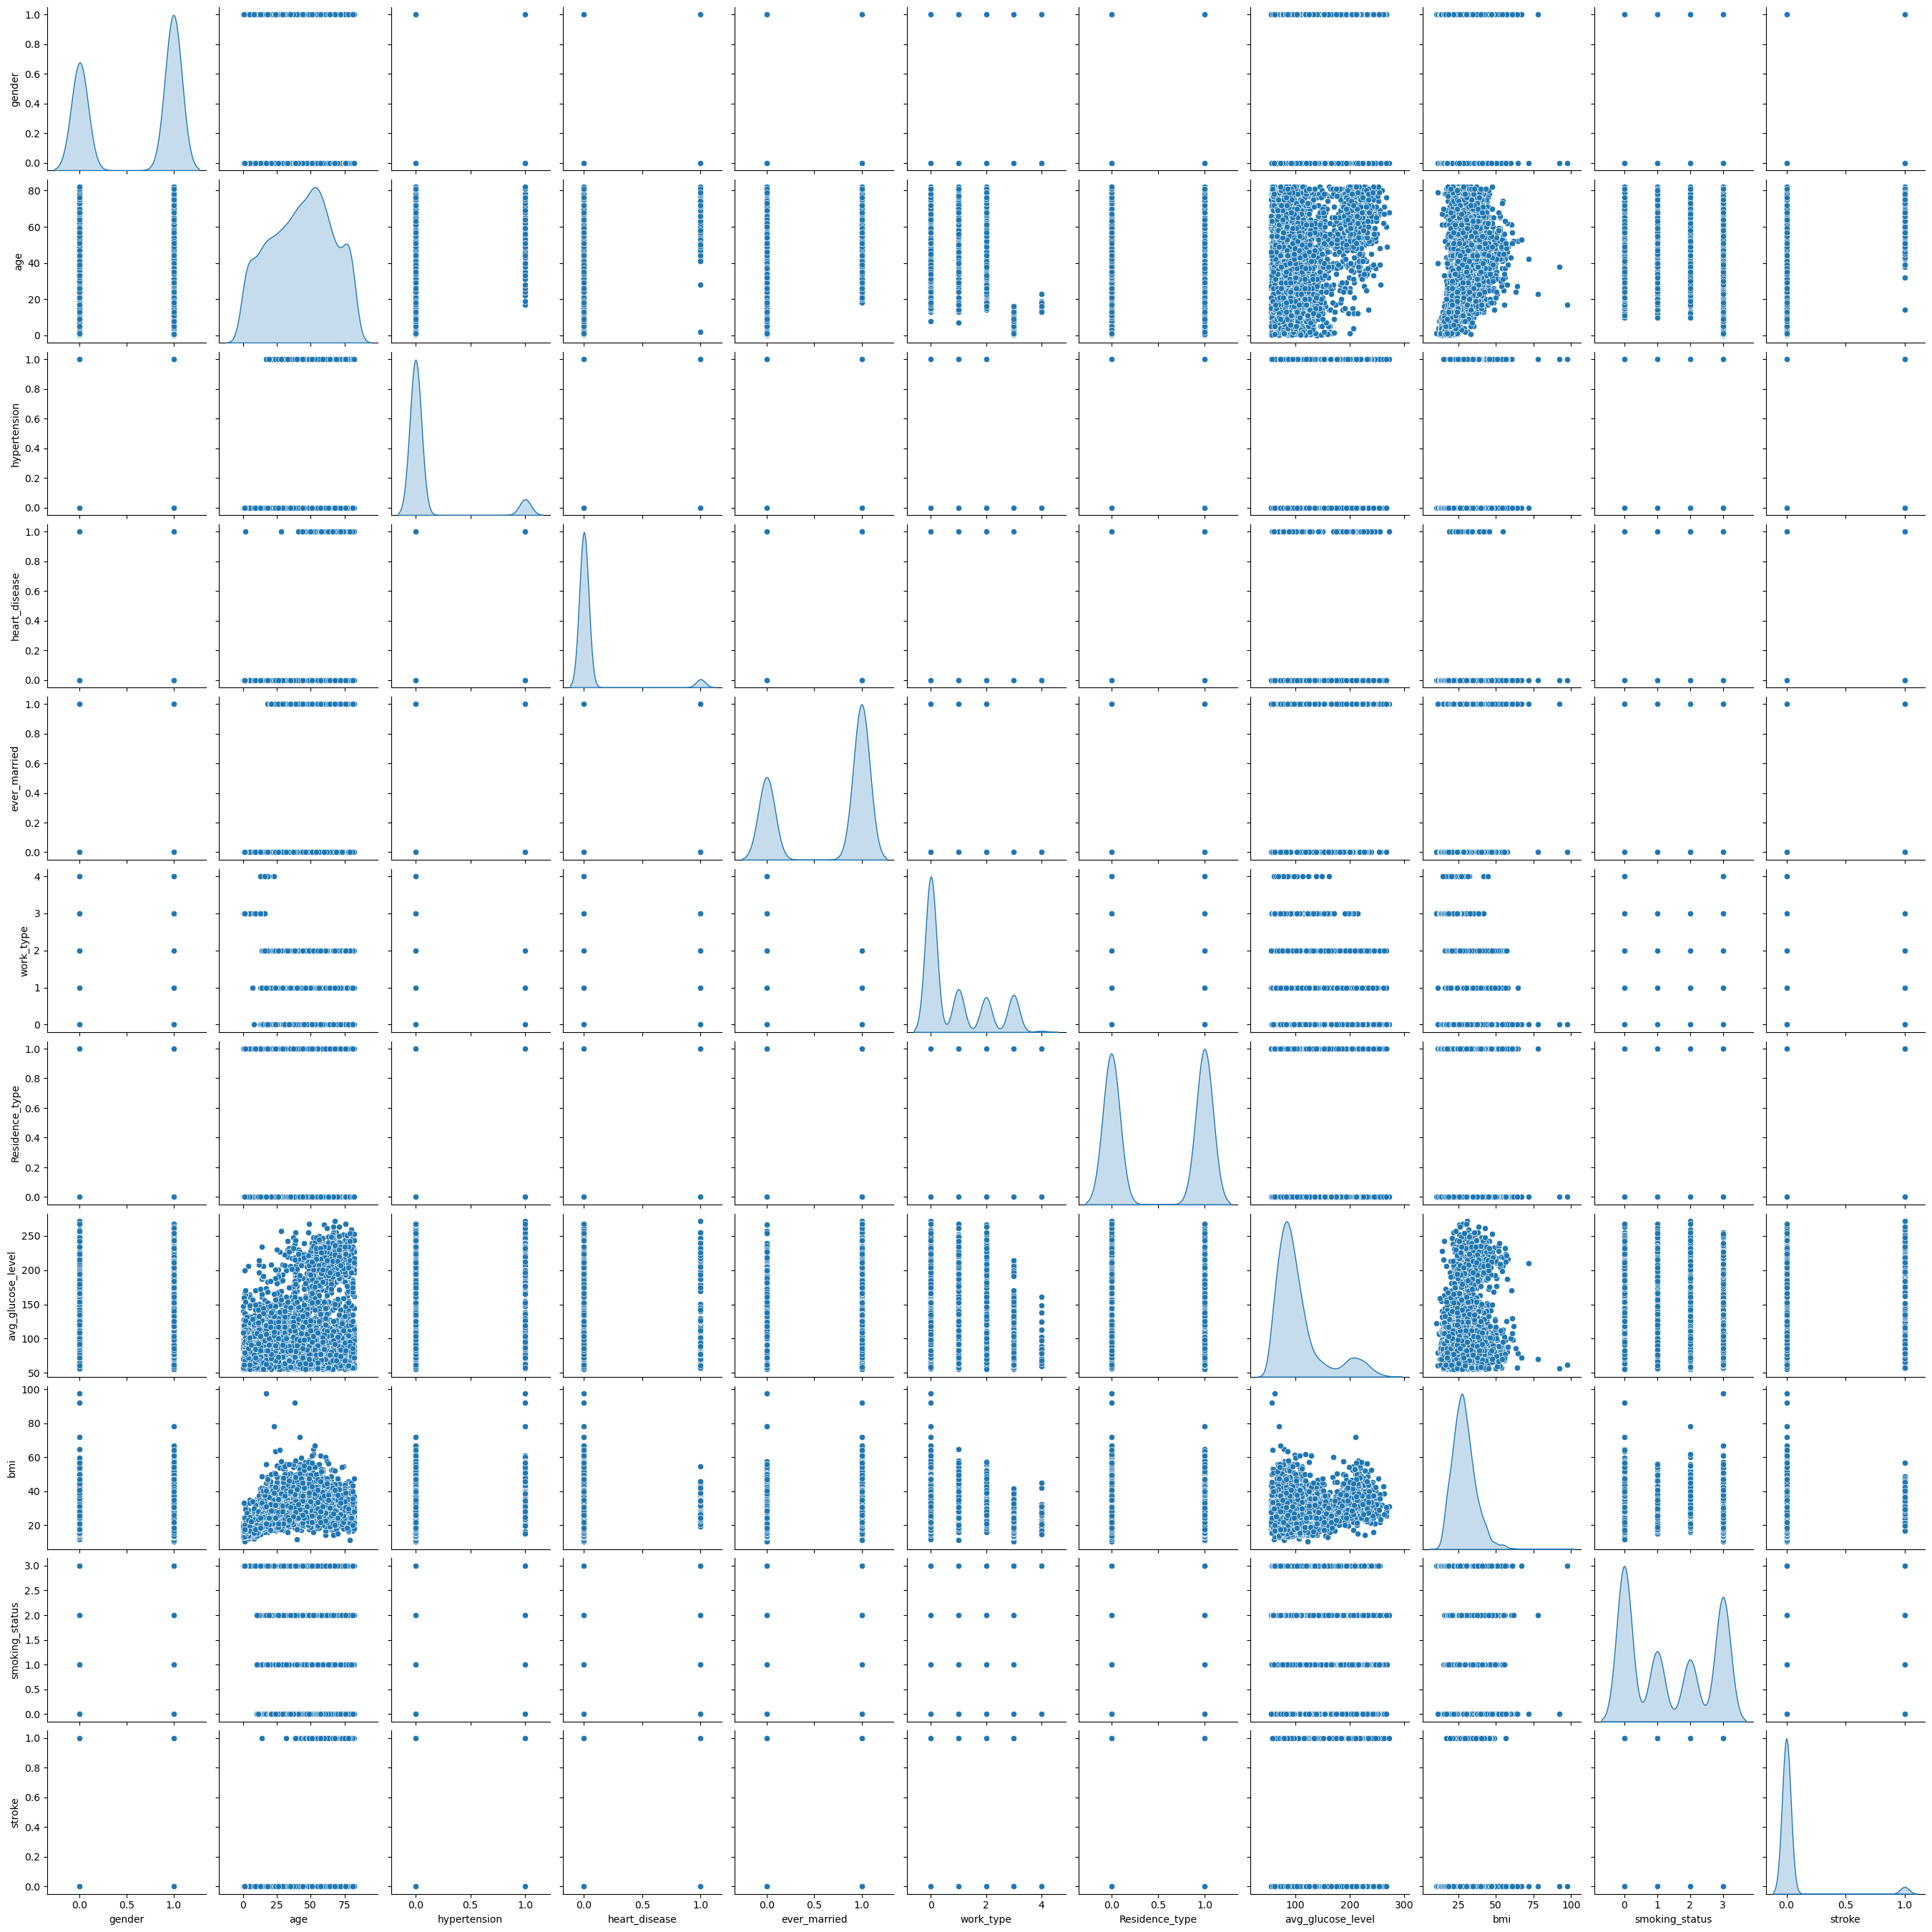

In [12]:
sns.pairplot(df, diag_kind = "kde")
plt.show()

In [13]:
# add constant
X = add_constant(df.drop(columns = ["stroke"]))

# VIF calculate
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

             Variable        VIF
0               const  30.502266
1              gender   1.020497
2                 age   2.289818
3        hypertension   1.114328
4       heart_disease   1.104198
5        ever_married   1.955338
6           work_type   1.358039
7      Residence_type   1.000841
8   avg_glucose_level   1.103321
9                 bmi   1.254202
10     smoking_status   1.171723


### 3.4 Data imbalance dignosis

Stroke is the dependent variable for this project. It is a binary categorical variable that shows whether the patient suffered from a stroke. To check for data imbalance based on the stroke feature, a graph was generated and the percentage of stroke occurrences among patients was calculated. The graph and the percentage of stroke occurrence indicated that the dataset has an imbalance issue.

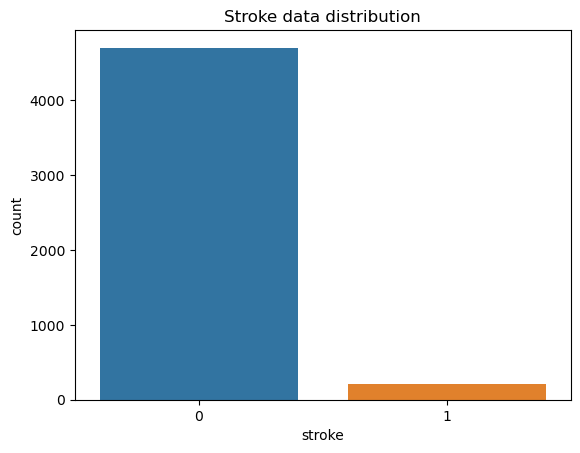

stroke
0    0.957416
1    0.042584
Name: proportion, dtype: float64


In [14]:
#check data imbalance
sns.countplot(x = "stroke", data = df)
plt.title("Stroke data distribution")
plt.show()

stroke_counts = df["stroke"].value_counts(normalize = True)
print(stroke_counts)

#data imbalance

### 3.5 EDA conclusion

During the EDA performed on the data, each feature's distribution and shape were explored. One correlation, between age and marriage status, was considered strong. Six moderate correlations between features were identified by inspecting the heat map. No collinearity was identified from the pair plot, and this was confirmed by the VIF test. Several outliers were found in the average glucose level. However, the decision was made not to drop these outliers because these outliers may be meaningful points for stroke prediction. Additionally, data imbalance was found in the dependent variable. Based on these facts, additional data cleaning will not be necessary. However, before performing the three types of machine learning models, three steps will be taken:

1. Perform SMOTE to solve the data imbalance problem.

2. Scale the continuous features for distance-based machine learning models.

3. Conduct feature engineering (one-hot encoding) for non-binary categorical features to improve model performance.

# 4. Models
In this section, as mentioned in the previous section, SMOTE, scaling, and one-hot encoding will be performed first. After these steps, three different machine learning models will be implemented: logistic regression, KNN, and random forest. Each model will have a base model and a refined model. To create the refined models, appropriate methods such as hyperparameter tuning or feature selection will be applied. As observed in the EDA section, the potential effect of collinearity is not expected to be significant during this phase.

### 4.1 Preperation
Before creating and fitting the model, as mentioned earlier, three different techniques will be performed in this section. These three methods will reduce the impact of data imbalance and improve model performance.

1. scaling
2. smote
3. feature engineering

#### 4.1.1 Data Scaling

In [15]:
#scaling for KNN 
scaler = StandardScaler()
df[["age", "avg_glucose_level", "bmi"]] = scaler.fit_transform(df[["age", "avg_glucose_level", "bmi"]])

#### 4.1.2 One-hot encoding

In [ ]:
#apply one-hot encoding to non-binary categorical variables
df = pd.get_dummies(df, columns = ["work_type"], drop_first = True, dtype = int)
df = pd.get_dummies(df, columns = ["smoking_status"], drop_first = True, dtype = int)

#### 4.1.3 SMOTE

In [17]:
#apply SMOTE for solve data imbalance problem
X = df.drop(columns = ["stroke"])
y = df["stroke"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE")
print(y_train.value_counts(normalize = True))

print("Before SMOTE")
print(y_train_smote.value_counts(normalize = True))

Before SMOTE
stroke
0    0.957463
1    0.042537
Name: proportion, dtype: float64
Before SMOTE
stroke
0    0.5
1    0.5
Name: proportion, dtype: float64


### 4.2 Logistic regression

The first machine learning model is logistic regression. Logistic regression analyzes the linear relationship between features and the target variable. This method helps identify which features affect stroke occurrence and the magnitude of their impact. Moreover, logistic regression is cost-effective and easy to train. It is useful for real-time prediction.

The strategy for this model begins with constructing a base model using all features. After that, feature selection will be used to investigate the best feature combination. The selected features will be applied to the final model. The results of the comparison between the base model and the final model will be displayed using different metrics, and the ROC-AUC score plot will also be shown for both.

#### 4.2.1 Base model creation

This is the base logistic regression model, created by using SMOTE on X_train and y_train to train the model.

In [18]:
#create logistic regression base model
logistic_base_model = LogisticRegression(random_state = 42).fit(X_train_smote, y_train_smote)

# make prediction with test data
y_pred_base_model = logistic_base_model.predict(X_test)
y_pred_proba_base_model = logistic_base_model.predict_proba(X_test)[:, 1]

#### 4.2.2 Feature Selection

In this section, the best features will be calculated by adjusting the C value, penalty, and solver of the LogisticRegression function. The C value will be set to a low value for stronger regularization, which will help prevent overfitting the model. The penalty will be set to L1, which is commonly used for feature selection in logistic regression. Moreover, the liblinear solver is typically paired with the L1 penalty. As a result, the liblinear solver will be used.

In [19]:
temp_model = LogisticRegression(C = 0.01, penalty = "l1", solver = "liblinear")

# Selecting Best features for logistic regression
selector = SelectFromModel(estimator = temp_model).fit(X_train_smote, y_train_smote)

# recontruct data with selected features
X_train_selected = selector.transform(X_train_smote)
X_test_selected = selector.transform(X_test)

#### 4.2.3 Final model training

This is the final model with the selected features from the section above. The y predictions and y prediction probabilities will be calculated using the final training model.

In [20]:
logistic_final_model = LogisticRegression(random_state = 42, max_iter = 1000).fit(X_train_selected, y_train_smote)

# make prediction for regression final model
y_pred_final = logistic_final_model.predict(X_test_selected)
y_pred_proba_final = logistic_final_model.predict_proba(X_test_selected)[:, 1]

#### 4.2.4 Feature importance

seven features were selected through feature selection. Especially, age was shown as the most important feature in this model. Smoking status(never smoked), work type(government job), and work type(self-employed) followed. The two major features that increase stroke occurrence are age and average glucose level. The three major features that decrease the possibility of stroke are work type(government job), work type(self-employed) and smoking status(never smoking).

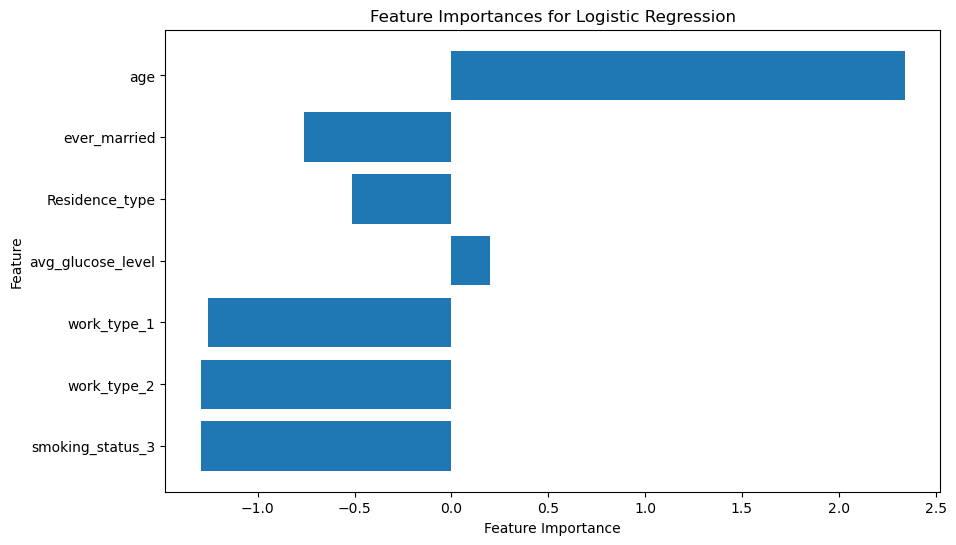

In [21]:
feature_importance = logistic_final_model.coef_[0]

new_features = X_train_smote.columns[selector.get_support()]

# visualizing feature importance
plt.figure(figsize = (10, 6))
plt.barh(new_features, feature_importance)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances for Logistic Regression")
plt.gca().invert_yaxis()
plt.show()

### 4.3 KNN

The second machine learning model is KNN. KNN is a distance-based model that can handle non-linear relationships between features. It will predict stroke based on the similarity of features. Moreover, KNN is flexible and intuitive, which means that KNN can be very effective if the data is atypical.

The strategy for this model begins with creating a base model using all features. After that, hyperparameter tuning will be performed to refine the final model. The results of the comparison between the base model and the final model will be displayed using different metrics, and the ROC-AUC score plot will also be shown for both.

#### 4.3.1 Base model

This is the base KNN model, created by using SMOTE on X_train and y_train to train the model.

In [22]:
#create base KNN model
knn_base = KNeighborsClassifier().fit(X_train_smote, y_train_smote)

# make prediction with test data
y_pred_base_knn = knn_base.predict(X_test)
y_pred_proba_base_knn = knn_base.predict_proba(X_test)[:, 1]

#### 4.3.2 Feature Selection

For this model, feature selection is not needed. This is because KNN is a distance-based model, and all features in this model are considered equally important.

#### 4.3.3 Hyperparameter tuning

n the KNN model, GridSearchCV will derive the best hyperparameter combination and prevent overfitting by using cross-validation. In this project, increasing the correct prediction rate of stroke is important, so GridSearchCV is the best option for the KNN model, even though the cost is a little higher compared to other methods.

In [23]:
knn = KNeighborsClassifier()

# hyper parameters setting
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],  
    "weights": ["uniform", "distance"],  
    "metric": ["euclidean", "manhattan"]  
}

# hyperparameter tuning with GridSearchCV
grid_search_knn = GridSearchCV(knn, 
                               param_grid, 
                               cv = 3, 
                               scoring = "roc_auc", 
                               verbose = 1, 
                               n_jobs = -1).fit(X_train_smote, y_train_smote)

# make predition with best model
best_knn = grid_search_knn.best_estimator_
y_pred_knn_final = best_knn.predict(X_test)
y_pred_proba_knn_final = best_knn.predict_proba(X_test)[:, 1]

Fitting 3 folds for each of 20 candidates, totalling 60 fits


#### 4.3.4 Final model
This is the final model with the hyperparameter tuning from the section above. The y predictions and y prediction probabilities will be calculated using the final training model.

In [24]:
best_knn = grid_search_knn.best_estimator_

y_pred_knn_final = best_knn.predict(X_test)
y_pred_proba_knn_final = best_knn.predict_proba(X_test)[:, 1]

### 4.4 Random Forest

The last machine learning model is Random Forest. Random Forest is an ensemble learning method that combines several decision trees to make predictions. Each tree is trained independently with randomly selected features. Random Forest provides high accuracy and helps prevent overfitting.

The strategy for this model begins with creating a base model using all features. In this model, selecting the best feature is a built-in function, so no additional code block for feature selection is needed. After that, hyperparameter tuning will be performed to refine the final model. The results of the base model and the final model will be displayed, along with the calculated ROC-AUC in a plot.The results of the comparison between the base model and the final model will be displayed using different metrics, and the ROC-AUC score plot will also be shown for both.

 

#### 4.4.1 Base model

This is the base random forest model, created by using SMOTE on X_train and y_train to train the model.

In [25]:
# create random forest base model
rf_base = RandomForestClassifier(random_state = 42).fit(X_train_smote, y_train_smote)

# make prediction with x test data.
y_pred_rf_base = rf_base.predict(X_test)
y_pred_proba_rf_base = rf_base.predict_proba(X_test)[:, 1]


#### 4.4.2 Feature selection

Random Forest has built-in feature selection. Therefore, additional feature selection is not needed.

#### 4.4.3 Hyperparameter tuning

In this section, GridSearchCV will be performed for the same reason as mentioned in KNN.

In [34]:
rf = RandomForestClassifier(random_state = 42)

# setting hyper params
param_grid = {
    "n_estimators": [50, 75, 100, 125],  
    "max_depth": [None, 10, 15, 20], 
    "min_samples_split": [2, 5, 10], 
    "min_samples_leaf": [1, 2, 4],  
    "bootstrap": [True, False]  
}

# hyperparameter tunning
grid_search_rf = GridSearchCV(rf, 
                              param_grid, 
                              cv = 3, 
                              scoring = "roc_auc", 
                              verbose = 1, 
                              n_jobs = -1).fit(X_train_smote, y_train_smote)

# make prediction with best model
best_rf = grid_search_rf.best_estimator_
y_pred_rf_final = best_rf.predict(X_test)
y_pred_proba_rf_final = best_rf.predict_proba(X_test)[:, 1]

Fitting 3 folds for each of 288 candidates, totalling 864 fits


#### 4.4.4 feature importance

The feature importance of the random forest is shown in the plot below. In this model, 15 features were considered, and there were three notable features: age, average_glucose_level, and BMI.

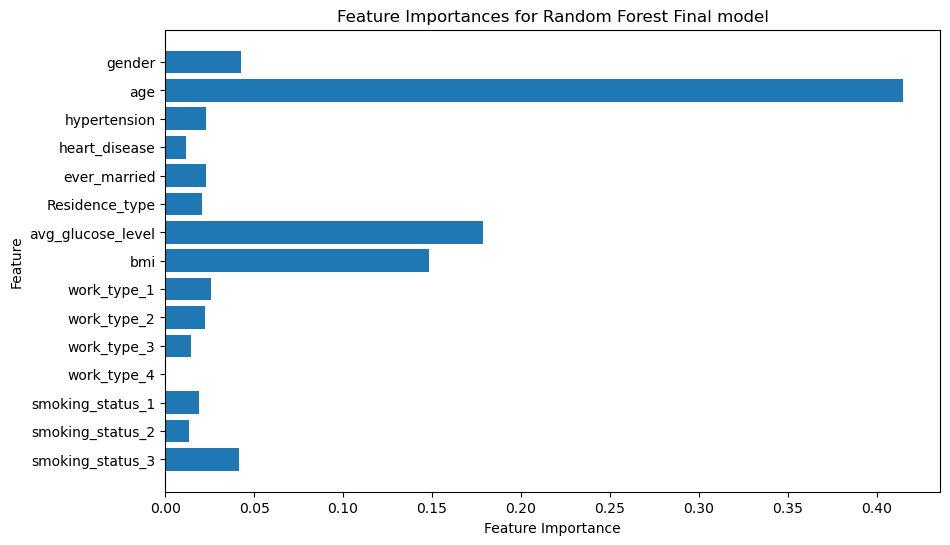

In [27]:
feature_importances = best_rf.feature_importances_

new_features = X_train_smote.columns

plt.figure(figsize = (10, 6))
plt.barh(new_features, feature_importances)
plt.title("Feature Importances for Random Forest Final model")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

# 5. Analysis and Result
In this section, an analysis of the two models from each machine learning technique will be performed based on several metrics. The ROC-AUC score comparison will also be displayed for each. At the end of this section, the best model for stroke prediction in this project will be judged by the metrics and chosen.

## 5.1 analysis

In this section, the two models from each machine learning technique will be compared using various metrics. The models will be evaluated using different metrics: the confusion matrix, precision, recall, F1-score, and ROC-AUC scores. The reason for using those metrics is due to the imbalance problem in the original dataset. Accuracy will not be considered because of this imbalance problem.

Here's breif explanation of each matrix.

1. Confusion Matrix
    + it shows how well the model predicts
    + TP, TN, FP, FN are present
    <br><br>

2. Precision
    + it shows the rate of samples predicted as postive that are actually positive.
    + TP / (TP + FP)
    <br><br>
3. Recall
    + it shows how well the model identifies the real positive samples
    + TP / (TP + FN)
    <br><br>
4. F1-score 
    + it shows balance between the precision and recall
    + (2 * precision * recall) / (precision + recall)
    <br><br>
5. ROC-AUC Score
    + it shows overall performance of the model 
    + TPR = TP / (TP + FN)
    + FPR = FP / (FP TN)
    <br><br>
    
Because of the efficiency of selecting feature, the **SelectFromModel** function was utilized in the model section instead of manually iterating through features to build the model.

### 5.1.1 Logistic Regression
When comparing the two model of Logistic regression, the final model showed increasing in the number of TP(24 -> 27) and FP(192 -> 193) and reducing the number of FN(18 -> 15) and TN(748 -> 747) compared to the base model. This indicates that the final model has slightly better performance to classify possitive cases (stroke, yes),  but performs slightly worse in classifying negative cases (stroke, no).

By checking the classification report of possitive value(stroke, yes), final model perform better in overall in three metrics: precision, recall, and f1-score

+ base model: 
    + precision: 0.11
    + recall: 0.57
    + F1-score: 0.19
    
+ final model:
    + precision: 0.12
    + recall: 0.64
    + F1-score: 0.21
    
The ROC-AUC score for final model slightly improved(0.79 -> 0.8) compared to base model

#### 5.1.1.a Base model

Confusion Matrix for logistic regression base model:
[[748 192]
 [ 18  24]]

Classification Report for Base logistic regression Model: 
              precision    recall  f1-score   support

           0       0.98      0.80      0.88       940
           1       0.11      0.57      0.19        42

    accuracy                           0.79       982
   macro avg       0.54      0.68      0.53       982
weighted avg       0.94      0.79      0.85       982

 ROC-AUC Score of Base logistic regression model: 0.79


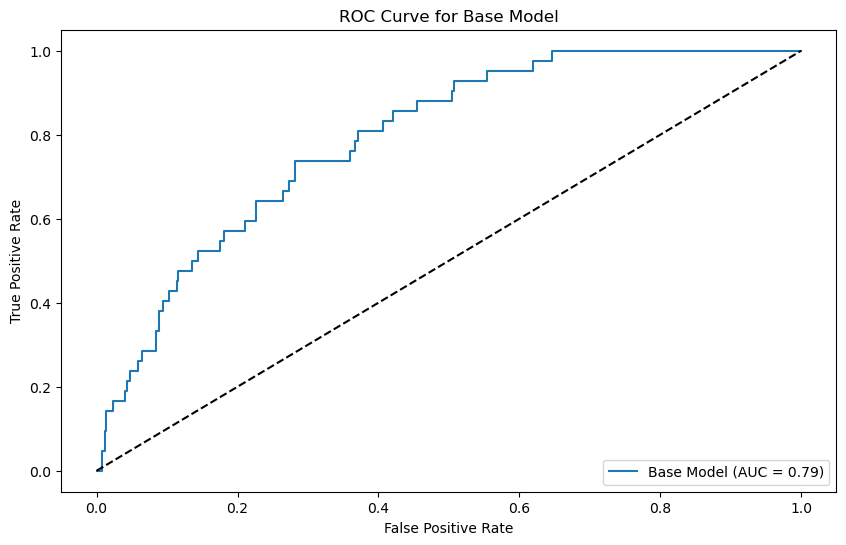

In [28]:
print("Confusion Matrix for logistic regression base model:")
print(confusion_matrix(y_test, y_pred_base_model))

# Classification Report 
print("\nClassification Report for Base logistic regression Model: ")
print(classification_report(y_test, y_pred_base_model))

# ROC-AUC calculate and print
roc_auc_base_model = roc_auc_score(y_test, y_pred_proba_base_model)
print(f" ROC-AUC Score of Base logistic regression model: {roc_auc_base_model:.2f}")

fp_rate_base_model, tp_rate_base_model, _ = roc_curve(y_test, y_pred_proba_base_model)

plt.figure(figsize = (10, 6))
plt.plot(fp_rate_base_model, tp_rate_base_model, label = f"Base Model (AUC = {roc_auc_base_model:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve for Base Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = "lower right")
plt.show()

#### 5.1.1.b Final model

Confusion Matrix for logistic regression Final model:
[[747 193]
 [ 15  27]]

Classification Report for Final Model: 
              precision    recall  f1-score   support

           0       0.98      0.79      0.88       940
           1       0.12      0.64      0.21        42

    accuracy                           0.79       982
   macro avg       0.55      0.72      0.54       982
weighted avg       0.94      0.79      0.85       982

 ROC-AUC Score for Final logistic regression model: 0.80


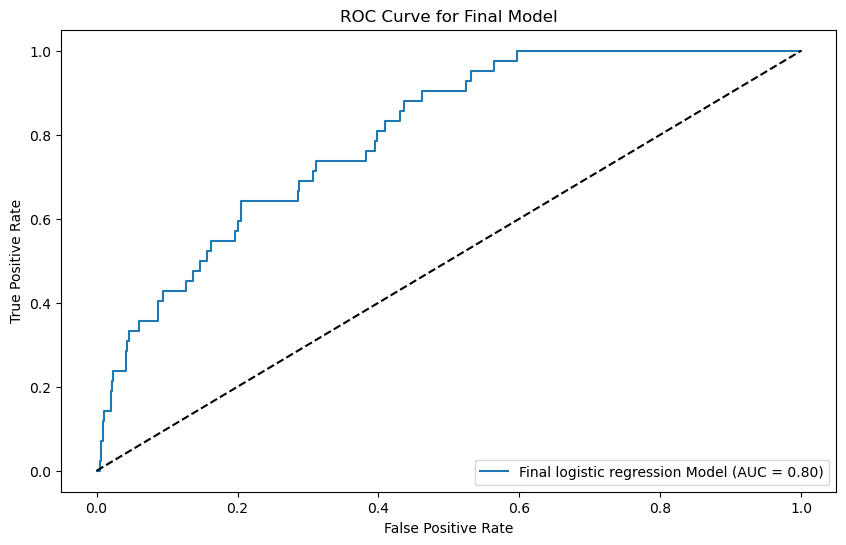

In [29]:
print("Confusion Matrix for logistic regression Final model:")
print(confusion_matrix(y_test, y_pred_final))

# Classification Report 
print("\nClassification Report for Final Model: ")
print(classification_report(y_test, y_pred_final))

# ROC-AUC calculate and print
roc_auc_final = roc_auc_score(y_test, y_pred_proba_final)
print(f" ROC-AUC Score for Final logistic regression model: {roc_auc_final:.2f}")

fp_rate_final, tp_rate_final, _ = roc_curve(y_test, y_pred_proba_final)

plt.figure(figsize = (10, 6))
plt.plot(fp_rate_final, tp_rate_final, label = f"Final logistic regression Model (AUC = {roc_auc_final:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve for Final Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = "lower right")
plt.show()

### 5.1.2 KNN
When comparing the two model of KNN,  the final model showed increasing in the number of TP(18 -> 19) and FP(170 -> 192) and reducing the number of FN(24 -> 23) and TN(770 -> 748) compared to the base model. This indicates that final model of KNN  slightly performs better to classify possitive value(stroke, yes),  but performs slightly worse in classifying negative value(storke, no).

By checking the classification report of possitive value(stroke, yes) for both, final model perform better in recall. However in other two metrics(precision and F1-score) final model performance decreased

+ base model: 
    + precision: 0.10
    + recall: 0.43
    + F1-score: 0.16
    
+ final model:
    + precision: 0.09
    + recall: 0.45
    + F1-score: 0.15
    
The ROC-AUC score for final model slightly improved(0.67 -> 0.72) compared to base model

#### 5.1.2.a Base model

Confusion Matrix for KNN Base model:
[[770 170]
 [ 24  18]]

Classification Report for KNN Base Model: 
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       940
           1       0.10      0.43      0.16        42

    accuracy                           0.80       982
   macro avg       0.53      0.62      0.52       982
weighted avg       0.93      0.80      0.86       982

ROC-AUC Score of KNN Base model: 0.67


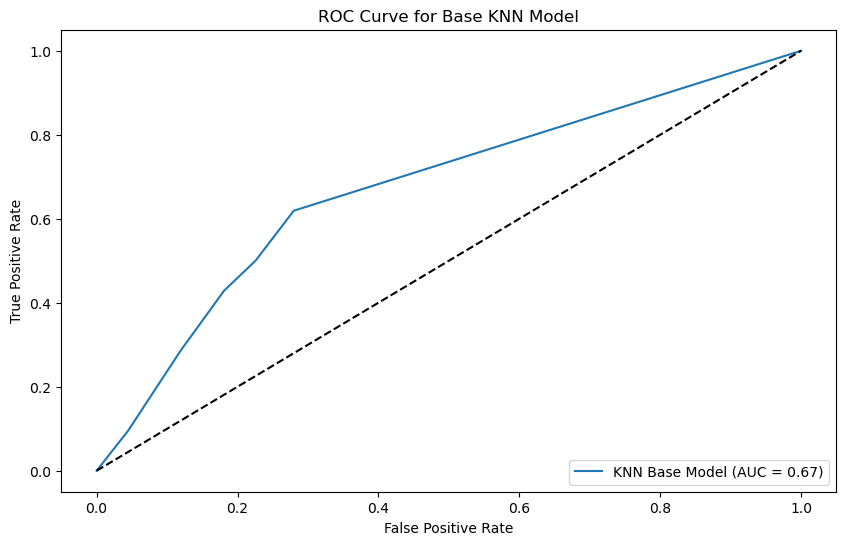

In [30]:
print("Confusion Matrix for KNN Base model:")
print(confusion_matrix(y_test, y_pred_base_knn))

# Classification Report 
print("\nClassification Report for KNN Base Model: ")
print(classification_report(y_test, y_pred_base_knn))

# ROC-AUC calculation and print
roc_auc_base_knn = roc_auc_score(y_test, y_pred_proba_base_knn)
print(f"ROC-AUC Score of KNN Base model: {roc_auc_base_knn:.2f}")

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_base_knn)

#visualization
plt.figure(figsize = (10, 6))
plt.plot(fpr_knn, tpr_knn, label = f"KNN Base Model (AUC = {roc_auc_base_knn:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve for Base KNN Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = "lower right")
plt.show()

#### 5.1.2.b Fianl model

Confusion Matrix for Final KNN Model:
[[748 192]
 [ 23  19]]

Classification Report for Final KNN Model:
              precision    recall  f1-score   support

           0       0.97      0.80      0.87       940
           1       0.09      0.45      0.15        42

    accuracy                           0.78       982
   macro avg       0.53      0.62      0.51       982
weighted avg       0.93      0.78      0.84       982

ROC-AUC Score for Final KNN Model - : 0.72


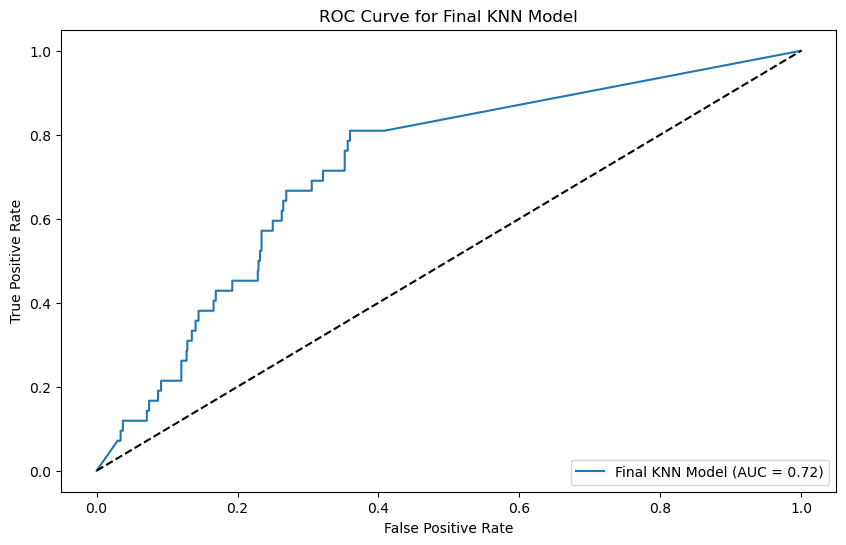

In [31]:
print("Confusion Matrix for Final KNN Model:")
print(confusion_matrix(y_test, y_pred_knn_final))

# Classification Report
print("\nClassification Report for Final KNN Model:")
print(classification_report(y_test, y_pred_knn_final))

# ROC-AUC calculation and print
roc_auc_knn_final = roc_auc_score(y_test, y_pred_proba_knn_final)
print(f"ROC-AUC Score for Final KNN Model - : {roc_auc_knn_final:.2f}")

#visualization
fpr_knn_final, tpr_knn_final, _ = roc_curve(y_test, y_pred_proba_knn_final)
plt.figure(figsize = (10, 6))
plt.plot(fpr_knn_final, tpr_knn_final, label = f"Final KNN Model (AUC = {roc_auc_knn_final:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve for Final KNN Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = "lower right")
plt.show()

### 5.1.3 Random Forest

When comparing the two model of Random Forest, the final model showed increasing in the number of TN(878 -> 884) and reducing the number of FP(62 -> 56). TP and FN are remaining same compared to the base model. This indicates that the final model performs to classify negative value(stroke, no) but, performance to classify possitive value(stroke, yes) didn't changed.

By checking the classification report of possitive value(stroke, yes) for both, final model perform better in precision and F1-score. However in other two metrics(precision and F1-score) final model performance decreased

+ base model: 
    + precision: 0.06
    + recall: 0.10
    + F1-score: 0.07
    
+ final model:
    + precision: 0.07
    + recall: 0.10
    + F1-score: 0.08
    
The ROC-AUC score for final model slightly improved(0.67 -> 0.72) compared to base model

####  5.1.3.a Base model

Confusion Matrix for Random Forest Base Model:
[[878  62]
 [ 38   4]]

Classification Report Random Forest Base Model:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       940
           1       0.06      0.10      0.07        42

    accuracy                           0.90       982
   macro avg       0.51      0.51      0.51       982
weighted avg       0.92      0.90      0.91       982

ROC-AUC Score for Random Forest Base Model: 0.75


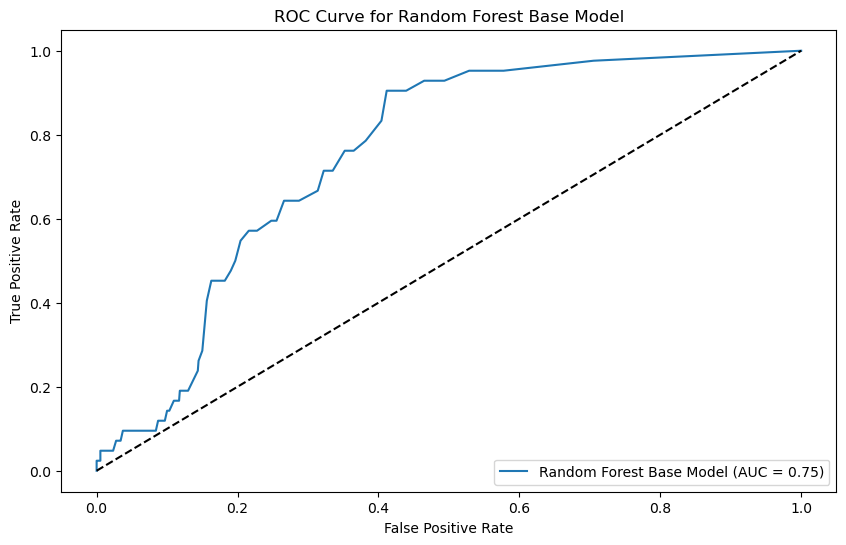

In [32]:
print("Confusion Matrix for Random Forest Base Model:")
print(confusion_matrix(y_test, y_pred_rf_base))

# Classification Report 
print("\nClassification Report Random Forest Base Model:")
print(classification_report(y_test, y_pred_rf_base))

# ROC-AUC calculation and print
roc_auc_rf_base = roc_auc_score(y_test, y_pred_proba_rf_base)
print(f"ROC-AUC Score for Random Forest Base Model: {roc_auc_rf_base:.2f}")

#visualization
fpr_rf_base, tpr_rf_base, _ = roc_curve(y_test, y_pred_proba_rf_base)
plt.figure(figsize = (10, 6))
plt.plot(fpr_rf_base, tpr_rf_base, label = f"Random Forest Base Model (AUC = {roc_auc_rf_base:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve for Random Forest Base Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = "lower right")
plt.show()

#### 5.1.3.b Final model

Confusion Matrix for Final Random Forest Model:
[[884  56]
 [ 38   4]]

Classification Report for Final Random Forest Model:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       940
           1       0.07      0.10      0.08        42

    accuracy                           0.90       982
   macro avg       0.51      0.52      0.51       982
weighted avg       0.92      0.90      0.91       982

ROC-AUC Score for Final Random Forest Model: 0.74


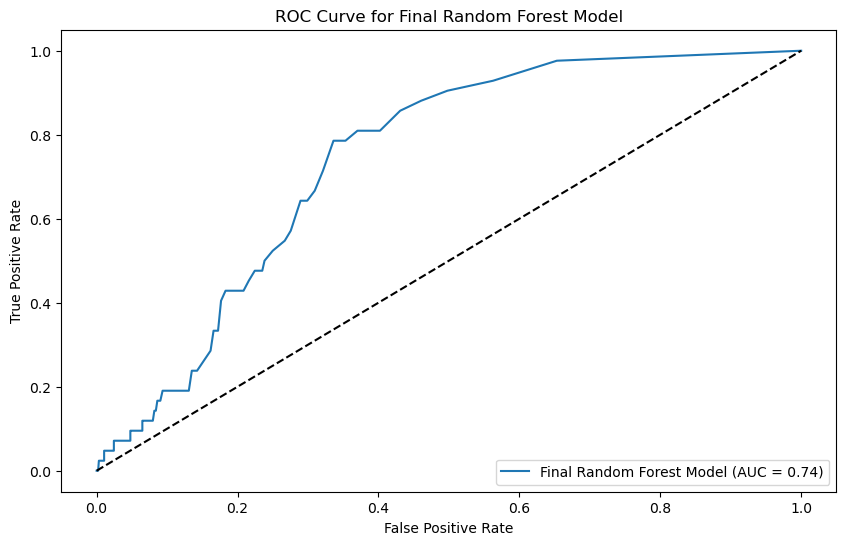

In [33]:
print("Confusion Matrix for Final Random Forest Model:")
print(confusion_matrix(y_test, y_pred_rf_final))

# Classification Report
print("\nClassification Report for Final Random Forest Model:")
print(classification_report(y_test, y_pred_rf_final))

# ROC-AUC calculation and print
roc_auc_rf_final = roc_auc_score(y_test, y_pred_proba_rf_final)
print(f"ROC-AUC Score for Final Random Forest Model: {roc_auc_rf_final:.2f}")

#visualization
fpr_rf_final, tpr_rf_final, _ = roc_curve(y_test, y_pred_proba_rf_final)
plt.figure(figsize = (10, 6))
plt.plot(fpr_rf_final, tpr_rf_final, label = f"Final Random Forest Model (AUC = {roc_auc_rf_final:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve for Final Random Forest Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = "lower right")
plt.show()

## 5.2 Result

To sum up, both the base model and the final model were created for each machine learning model (Logistic Regression, KNN, and Random Forest) in the model section. In the analysis section, two versions of each model were compared. Additionally, three features that increase the possibility of stroke occurrence were identified which are age, BMI, and average glucose level. Finally, Logistic regression was selected as the most suitable model for stroke prediction among the three final models. The main considerations are outlined below.

1. **Stroke can occur to anyone at anytime. If a stroke occur, there would be significant impact on daily life. Thus key consideration is identifying the possitive case of stroke(Storke, yes).**

2. **Additionally performance of model was be considered too.**

Based on the above considerations, Logistic Regression was determined to be the best model among the three final models. The model had the best performance in classifying positive cases (recall = 0.64) of stroke (stroke, yes), and its precision and F1-score were also higher compared to the other models. Furthermore, the overall performance of the model was the highest, (ROC-AUC score = 0.80).

# 6. Discussion and Conclusion


Throughout this project, by applying machine learning knowledge to real-world data, I felt I became more familiar with the concepts I learned in class. Moreover, it was a great opportunity to learn new concepts such as SMOTE and feature selection. However, there were also some shortcomings, such as the low precision of the models and the decrease in Random Forest performance after hyperparameter tuning. This was probably due to inappropriate approach to data imbalance problem and incorrect hyperparameter settings. To improve this issue and enhance my models, trying other techniques for solving data imbalance will be necessary. Additionally, further study and better tuning of hyperparameters will help overcome the shortcomings of the Random Forest model.


# Reference Citation

[1] Mundell, E. (2024, May 23). Stroke rates are rising, especially among the young. U.S. News & World Report. https://www.usnews.com/news/health-news/articles/2024-05-23/stroke-rates-are-rising-especially-among-the-young

[2] U.S. Department of Health and Human Services. (n.d.). Brain basics: Preventing stroke. National Institute of Neurological Disorders and Stroke. https://www.ninds.nih.gov/health-information/public-education/brain-basics/brain-basics-preventing-stroke 

[3] Soriano, F. (2021, January 26). Stroke prediction dataset. Kaggle. https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset 

# Github Repo


https://github.com/yongki0704/Stroke_prediction